## Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

# Исследуем общую информацию

### 1. Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pymystem3 import Mystem
from nltk.stem import SnowballStemmer 
russian_stemmer = SnowballStemmer('russian')
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

### 2. Читаем таблицу в переменную df (DataFrame) и сделаем резервную копию в переменной df_copy

Резервная копия трубется для того, чтобы в случае необходимости сравнить замененные ячейки

In [2]:
df = pd.read_csv('debt_dataset.csv')
df_copy = pd.read_csv('debt_dataset.csv')

### 3. Выведем первые пять строк полученной таблицы с помощью метода head(), а также еще пять случайных строк с помощью метода sample()

In [3]:
df.head(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [4]:
df.sample(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
7785,0,-1847.731652,37,среднее,1,женат / замужем,0,F,сотрудник,0,77051.284246,ремонт жилью
12115,0,-4060.498230,44,высшее,0,женат / замужем,0,M,сотрудник,0,283681.222896,операции с коммерческой недвижимостью
8359,0,-518.974318,40,ВЫСШЕЕ,0,гражданский брак,1,F,компаньон,0,230141.147194,на проведение свадьбы
15920,2,-781.707436,36,среднее,1,Не женат / не замужем,4,F,компаньон,0,234660.603131,жилье
5498,0,-6511.621133,60,Среднее,1,вдовец / вдова,2,F,сотрудник,0,174995.741267,покупка коммерческой недвижимости


**Предварительные выводы на основе первого визуального ознакомления**:
- в таблице не требуется переименовывать заголовки,
- в столбце days_employed есть отрицательные значения, с которыми нужно будет что-то делать,
- days_employed для упрощения восприятия нужно будет пересчитать в годах и привести к целочисленному типу,
- в отношении total_income потребуется округление до двух знаков,
- возможно упростить столбец family_status,
- столбец purpose потребует переработки - назначение кредита надо будет обобщать.
- строчные данные в таблице внесены в разном регистре.

**На разрешение поставлены следующие вопросы:**
- есть ли зависимость между семейным положением и возвратом кредита в срок?
- есть ли зависимость между уровнем дохода и возвратом кредита в срок?
- как разные цели кредита влияют на его возврат в срок?

**Исходя из поставленных вопросов ключевыми столбцами являются "children", "family_status", "total_income", "purpose".**

**Вместе с тем, очистка будет проводиться по всем данным, со всеми столбцами: это позволит заполнить пропуски и устранить "странные" данные. Кроме того, данные по другим столбцам могут понадобиться для дальнейшего анализа**

### 4. Получим общую информацию о таблице с помощью метода info()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


**Всего 21 525 строк. В таблице есть пропущенные данные: в столбцах days_employed и total_income - 2 174 строки. На первый взгляд, нет больших проблем с типами данных**.

### 5. Получим дополнительные сведения о данных в таблице с помошью метода describe() и corr(): каков диапазон значений в данных, какова корреляция между парами наблюдений

In [6]:
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


#### Проверим какие из наблюдений взаимосвязаны и взаимозаисимы между собой в том виде, каком они представлены сейчас с помощью метода corr(). Интересно будет сравнить цифры после очистки данных.

In [7]:
df.corr()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
children,1.000000,-0.138354,-0.174358,-0.012695,-0.091284,0.018470,0.018220
days_employed,-0.138354,1.000000,0.582643,0.080565,0.005726,-0.047110,-0.136648
dob_years,-0.174358,0.582643,1.000000,0.067467,-0.069988,-0.069620,-0.052911
education_id,-0.012695,0.080565,0.067467,1.000000,0.007876,0.052906,-0.178885
family_status_id,-0.091284,0.005726,-0.069988,0.007876,1.000000,0.020611,-0.009147
debt,0.018470,-0.047110,-0.069620,0.052906,0.020611,1.000000,-0.012475
total_income,0.018220,-0.136648,-0.052911,-0.178885,-0.009147,-0.012475,1.000000


**Выводы**:
- разброс по количеству детей от -1 до 20,
- в данных с трудовым стажем есть не только отрицательные значения, но еще и очевидно бессмысленные наблюдения: максимальный трудовой стаж равен 1100 годам (401 755 дней),
- в столбце с возрастом заемщиков есть значения равные 0,
- в данном виде наблюдается слабая корреляция между наблюдениями и возникшим долгом. Сравним результат после очистки данных.


### 6. С учетом полученных данных посмотрим отдельно в столбцы

#### 1) Посчитаем сколько строк содержат данные о количестве детей более 10

In [8]:
df[df.children > 10].count()

children            76
days_employed       67
dob_years           76
education           76
education_id        76
family_status       76
family_status_id    76
gender              76
income_type         76
debt                76
total_income        67
purpose             76
dtype: int64

**Семьдесят шесть строк. Менее 1 % (76 / 21 525). Возможно, эти строки можно выкинуть без существенного вреда для результата.**

#### 2) Посчитаем сколько строк содержат данные о возрасте равным 0

In [9]:
df[df.dob_years == 0].count()

children            101
days_employed        91
dob_years           101
education           101
education_id        101
family_status       101
family_status_id    101
gender              101
income_type         101
debt                101
total_income         91
purpose             101
dtype: int64

**Сто одна строка. Также менее 1 % (101 / 21 525). Возможно, эти строки также можно выкинуть без существенного вреда для результата.**

#### 3) Проверим, пересекаются ли строки с возрастом равным нулю и количеством детей более 10

In [10]:
df[(df.dob_years == 0) & (df.children > 10)].count()

children            1
days_employed       1
dob_years           1
education           1
education_id        1
family_status       1
family_status_id    1
gender              1
income_type         1
debt                1
total_income        1
purpose             1
dtype: int64

**Всего одно пересечение. Следовательно 177 строк c бессмысленными данными, что все еще менее 1% от всех наблюдений (177 / 21 525). Претенденты на удаление.**

#### 4) Дополнительно проверим насколько часто встречаются отрицательные значения в столбце об общем трудовом стаже

In [11]:
df[df.days_employed < 0].count()

children            15906
days_employed       15906
dob_years           15906
education           15906
education_id        15906
family_status       15906
family_status_id    15906
gender              15906
income_type         15906
debt                15906
total_income        15906
purpose             15906
dtype: int64

**Неожиданно 74% всех наблюдений (15 906 / 21 525).**

При обзоре таблицы найдены значения с трудовом стаже исчисляющемся в тысячелетиях - очевидная техническая ошибка. Например, мужчина с 18 лет до 65 лет будет работать всего 47 лет или 17 155‬ дней (47 * 365). Узнаем сколько наблюдений в таблице с трудовым стажем свыше 47 лет.

In [12]:
goofy_employee_days = len(df[df.days_employed >= 17155])
goofy_employee_days_percent = goofy_employee_days / len(df)
print('В выборке {} наблюдений непрерывного стажа свыше 47 лет, что составляет {:.2%} от всей выборки из 21 525 наблюдений.'.format(goofy_employee_days, goofy_employee_days_percent))

В выборке 3445 наблюдений непрерывного стажа свыше 47 лет, что составляет 16.00% от всей выборки из 21 525 наблюдений.


#### 5) Проверим содержимое столбцов family_status, gender,	income_type, purpose

- семейное положение

In [13]:
df.family_status.unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'Не женат / не замужем'], dtype=object)

- пол

In [14]:
df.gender.unique()

array(['F', 'M', 'XNA'], dtype=object)

- источник дохода

In [15]:
df.income_type.unique()

array(['сотрудник', 'пенсионер', 'компаньон', 'госслужащий',
       'безработный', 'предприниматель', 'студент', 'в декрете'],
      dtype=object)

- образование

In [16]:
df.education.unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

- цель кредита

In [17]:
df.purpose.unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

#### 6) Проверим таблицу на наличие дубликатов

In [18]:
df.duplicated().value_counts()

False    21471
True        54
dtype: int64

**Найден 54 дубликата: менее одного процента (54 / 21 525).**

**Поскольку всего дублей всего 54 - выведем все дублирующиеся значения, чтобы понять причину возникновения дублей.**

In [19]:
df[df.duplicated()].sort_values(by = 'purpose')

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
13639,0,NaN,64,среднее,1,женат / замужем,0,F,пенсионер,0,NaN,автомобиль
16378,0,NaN,46,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,высшее образование
20702,0,NaN,64,среднее,1,женат / замужем,0,F,пенсионер,0,NaN,дополнительное образование
8583,0,NaN,58,высшее,0,Не женат / не замужем,4,F,пенсионер,0,NaN,дополнительное образование
18428,0,NaN,64,среднее,1,женат / замужем,0,F,пенсионер,0,NaN,жилье
17755,1,NaN,43,среднее,1,женат / замужем,0,M,сотрудник,0,NaN,заняться образованием
12736,0,NaN,59,среднее,1,женат / замужем,0,F,пенсионер,0,NaN,заняться образованием
18755,0,NaN,58,среднее,1,женат / замужем,0,F,пенсионер,0,NaN,заняться образованием
21032,0,NaN,60,среднее,1,женат / замужем,0,F,пенсионер,0,NaN,заняться образованием
16904,1,NaN,32,высшее,0,женат / замужем,0,F,сотрудник,0,NaN,на покупку подержанного автомобиля


**По всей видимости причина возникновения дублей в отсутвующих данных. Трудовой стаж и доход - ключевые индивидулизирующие аттрибуты пропущены; остальные наблюдения - неинформативны. Кроме того, дубликаты не пересекаются со строками с бессмысленными данными. Возможно, данные строки проще всего удалить.**

**Выводы**:
- в столбцах с наблюдениями об образовании, семейном положении, поле различается регистр, в цели кредита - нет, 
- цель кредита и  семейное положение потребуется позже упростить,
- в столбце пол содержится значение 'XNA', которое требует замены,
- в таблице есть 71 дубликат, которые возникли из-за пропусков.

### 8. Посчитаем сколько всего строк в таблице с наблюдением о долге

In [20]:
df.debt.value_counts()

0    19784
1     1741
Name: debt, dtype: int64

**1741 наблюдение, почти 9% (1 741 / 19 784).**

### Вывод

**1.** В таблице содержится 21 525 наблюдений в которых 5 868‬ строк с пропусками, бессмысленными данными и дубликатами: 
    - 2 174 пропуска,
    - 3 623 бессмысленных значения,
    - 71 дубликат.
**2.** Необходимо исправить отрицательные значения в столбце days_employed. 

**3.** Столбец purpose потребует переработки – обобщить назначение кредита.

**4.** По крайней мере неочищенные данные показывают слабую корреляцию между наблюдениями.


# Предобработка данных

### Обработка пропусков

**1) Исправим регистр с помощью строкового метода str.lower().**

In [21]:
df.education = df.education.str.lower()
df.family_status = df.family_status.str.lower()
df.gender = df.gender.str.lower()

**Проверим результат**

In [22]:
df.education.unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

In [23]:
df.family_status.unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'не женат / не замужем'], dtype=object)

In [24]:
df.gender.unique()

array(['f', 'm', 'xna'], dtype=object)

**2) Избавимся от отрицательных значений в столюце с трудовым стажем и столбце с количеством детей**

In [25]:
df['days_employed'] = abs(df['days_employed'])

In [26]:
df['children'] = abs(df['children'])

**Проверим результат**

In [27]:
df.days_employed.min()

24.14163324048118

In [28]:
df.children.min()

0

**3) Заполним пропуски с доходом в столбце total_income**

Узнаем медиану для каждого из типов дохода с помощбю метода .groupby(), запустим цикл для заполнения пропусков медианным значением в зависимости от вида дохода.

**Важно отметить, что в каждой строке содержится данные о замещике - то есть лице, которое уже получило кредит. Следовательно, в таблице вообще не может быть дохода равного 0.**

In [29]:
df.groupby('income_type').total_income.median()

income_type
безработный        131339.751676
в декрете           53829.130729
госслужащий        150447.935283
компаньон          172357.950966
пенсионер          118514.486412
предприниматель    499163.144947
сотрудник          142594.396847
студент             98201.625314
Name: total_income, dtype: float64

In [30]:
income_type = ['сотрудник', 'пенсионер', 'компаньон', 'госслужащий', 'безработный', 'предприниматель', 'студент', 'в декрете']
for i in income_type:
    med_inc = int(df[df.income_type == i].total_income.median())
    df.loc[(df['total_income'].isna()) & (df.income_type == i), 'total_income'] = med_inc

**3) Заполним пропуски с возрастом в столбце days_employed**

Аналогично заполнению пропусков в столбце с доходом узнаем с помощью метода .groupby() медиану для общего стажа и запустим цикл для заполнения, принимая во внимание столбец с типом дохода (income_type)

In [31]:
df.groupby('income_type').days_employed.median()

income_type
безработный        366413.652744
в декрете            3296.759962
госслужащий          2689.368353
компаньон            1547.382223
пенсионер          365213.306266
предприниматель       520.848083
сотрудник            1574.202821
студент               578.751554
Name: days_employed, dtype: float64

**Прежде чем проводить замену пропуска нужно разобраться с бессмысленными данными о тысячелетнем стаже**. Компромисс на который придется пойти в отсутвии возможности запросить корректные данные у ответственного за сбор данных.
Принцип замены: 
- для женщин трудовой стаж не должен превышать 42 лет, 15 330 дней (60 - 18), 
- для мужчин трудовой стаж не должен превышать 47 лет, 17 155‬ дней (65 - 18).

In [32]:
for i in income_type:
    m_employee = 17155
    f_employee = 15330
    df.loc[(df.days_employed >= 17155) & (df.income_type == i) & (df.gender == 'm'), 'days_employed'] = m_employee
    df.loc[(df.days_employed >= 15330) & (df.income_type == i) & (df.gender == 'f'), 'days_employed'] = f_employee

<font color = green> Отличный ход</font>

In [33]:
df.groupby('income_type').days_employed.median()

income_type
безработный        16242.500000
в декрете           3296.759962
госслужащий         2689.368353
компаньон           1547.382223
пенсионер          15330.000000
предприниматель      520.848083
сотрудник           1574.202821
студент              578.751554
Name: days_employed, dtype: float64

In [34]:
for i in income_type:
    med_employee = int(df[df.income_type == i].days_employed.median())
    df.loc[(df['days_employed'].isna()) & (df.income_type == i), 'days_employed'] = med_employee

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       21525 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


**4) Исправим бессмысленные значения в таблице**

- **количество детей**: ранее было обаружены 76 строк с количеством детей равным 20, при этом стадартное отклонение значений равно 1.38, медианное - 0, а среднее 0.54. Веротяно причина появлений таких строк - техническая ошибка, поэтому значения будут заменены на 2, что соответствует выборке.

In [36]:
df.children.unique()

array([ 1,  0,  3,  2,  4, 20,  5], dtype=int64)

In [37]:
df.children.replace(20, 2, inplace = True)

In [38]:
df.children.unique()

array([1, 0, 3, 2, 4, 5], dtype=int64)

- **возраст**: были обнаружены строки со значением 0. Заполним строки по аналогии с заполненными NaN - то есть в зависимости от вида дохода.

In [39]:
df.dob_years.min()

0

In [40]:
for i in income_type:
    med_age = int(df[df.income_type == i].dob_years.median())
    df.loc[(df.dob_years == 0) & (df.income_type == i), 'dob_years'] = med_age

In [41]:
df.dob_years.min()

19

- **пол**: значение 'XNA'. Поскольку таблица не позволяет установить пол в зависимости от других значений - заменим 'xna' на 'm'.

In [42]:
df.gender.replace('xna', 'm', inplace = True)

In [43]:
df.gender.unique()

array(['f', 'm'], dtype=object)

- **трудовой стаж**: странные значения исправлены ранее компромиссной заменой на предельный возможный стаж

### Вывод

1. Произведена замена NaN в столбцах days_employed и total_income в зависимости от типа занятости.
2. Обнаружено, что в таблице есть близкие ярлыки, которые дублируют друг друга - по размеру дохода и общему стажу работы:
    - пенсионер и безработный,
    - сотрудник и компаньон.
3. В 3445 строках пришлось заменить данные о трудовом стаже на 17 155 для мужчин и 15 330‬ для женщин. Компромисс на который придется пойти в отсутвии возможности запросить корректные данные у ответственного за сбор данных сотрудника.
4. Исправлены бессмысленные значения в стобцах с количеством детей и возрасте.

### Замена типа данных

В столбцах доход и продолжительность трудового стажа заменим значения на целочисленные методом .astype(): в случае с трудовым стажем логично считать целые дни, а в отншении дохода дробная часть создает информационный шум, поскольку не содержит существенных сведений о доходе - в такой выборке значения после запятой мало влияют на результат, но мешают анализировать данные.

In [44]:
df['total_income'] = df.total_income.astype(int)
df['days_employed'] = df.days_employed.astype(int)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       21525 non-null int32
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null int32
purpose             21525 non-null object
dtypes: int32(2), int64(5), object(5)
memory usage: 1.8+ MB


### Вывод

В столбцах days_employed и total_income значения конвертированы из float в int. Поскольку ранее были заполнены пропуски - метод сработал без ошибок.

### Обработка дубликатов

Снова проверим наличие дубликатов в таблице

In [46]:
df.duplicated().value_counts()

False    21454
True        71
dtype: int64

После обработки пропусков, замены типов данных в таблице 71 дубликат, что составляет 0,0032984901277584‬ % от выборки. В таком случае самый простой и экономный способ - удалить дубликаты методом drop_duplicates().

In [47]:
df.drop_duplicates(inplace = True)

In [48]:
df.duplicated().value_counts()

False    21454
dtype: int64

### Вывод

Избавились от дубликатов пуем удаления ввиду несущественности для выборки. При общем обзоре DataFrame был сделан вывод, что причина возникновения дублей - в отсутвующих данных. Трудовой стаж и доход - ключевые индивидулизирующие аттрибуты были пропущены; остальные наблюдения - неинформативны. Как следствие, даже заполнение NaN не повлияло на исчезновние дубликатов, поскольку заполнение осуществлялось идентичными данными. 

### Лемматизация

Прежде всего ознакомимся с целями, ради которых обращались за кредитом в данной выборке

In [49]:
df.purpose.value_counts()

свадьба                                   791
на проведение свадьбы                     768
сыграть свадьбу                           765
операции с недвижимостью                  675
покупка коммерческой недвижимости         661
операции с жильем                         652
покупка жилья для сдачи                   651
операции с коммерческой недвижимостью     650
жилье                                     646
покупка жилья                             646
покупка жилья для семьи                   638
строительство собственной недвижимости    635
недвижимость                              633
операции со своей недвижимостью           627
строительство жилой недвижимости          624
покупка недвижимости                      621
покупка своего жилья                      620
строительство недвижимости                619
ремонт жилью                              607
покупка жилой недвижимости                606
на покупку своего автомобиля              505
заняться высшим образованием      

Основные цели - покупка недвижимости, оплата свадьбы, покупка автомобиля и получения образования. Лемматезируем значения в столбце назначения, чтобы в этом убедиться. **Поскольку лемматизация будет проводиться по столбцу, то есть по объекту Series, у которого в отличие от строк нет аттрибута 'splitlines', то скорее всего потребуется собрать все значения ячеек столбца purpose в один большой текст с помощью метода .join(). Но все таки попробуем сперва передать столбец напрямую.**

In [50]:
m = Mystem()
try:
    lemmas = m.lemmatize(df['purpose'])
except:
    lemmas = m.lemmatize(' '.join(df['purpose'].values))
    print('Как и предполагалось - пришлось использовать метод .join(). Зато все работает!')

Как и предполагалось - пришлось использовать метод .join(). Зато все работает!


In [51]:
lemmas_counter = dict(Counter(lemmas))

In [52]:
print(lemmas_counter)

{'покупка': 5897, ' ': 55023, 'жилье': 4460, 'приобретение': 461, 'автомобиль': 4306, 'дополнительный': 906, 'образование': 4013, 'сыграть': 765, 'свадьба': 2324, 'операция': 2604, 'с': 2918, 'на': 2222, 'проведение': 768, 'для': 1289, 'семья': 638, 'недвижимость': 6351, 'коммерческий': 1311, 'жилой': 1230, 'строительство': 1878, 'собственный': 635, 'подержать': 853, 'свой': 2230, 'со': 627, 'заниматься': 904, 'сделка': 941, 'получение': 1314, 'высокий': 1374, 'подержанный': 111, 'профильный': 436, 'сдача': 651, 'ремонт': 607, '\n': 1}


In [53]:
queries = []
for key, value in lemmas_counter.items():
    temp = key
    queries.append(temp)

stemmed_query = []
for word in queries:
    if len(word) > 3:
        stemmed_word = russian_stemmer.stem(word)
        stemmed_query.append(stemmed_word)

In [54]:
stemmed_query

['покупк',
 'жил',
 'приобретен',
 'автомобил',
 'дополнительн',
 'образован',
 'сыгра',
 'свадьб',
 'операц',
 'проведен',
 'сем',
 'недвижим',
 'коммерческ',
 'жил',
 'строительств',
 'собствен',
 'подержа',
 'сво',
 'занима',
 'сделк',
 'получен',
 'высок',
 'подержа',
 'профильн',
 'сдач',
 'ремонт']

### Вывод

**Как и ожидалось наиболее часто встречаются слова, в порядке очередности - "недвижимость", "жилье", "автомобиль", "образование", "свадьба", "строительство" а также с сильным отставанием - "ремонт" (607), что не было заметно при подсчете значений. Следовательно, основные цели ради которых получали кредиты (обобщая):**
- недвижимость,
- автомобиль,
- образование,
- ремонт,
- свадьба.

### Категоризация данных

В данных много единичных наблюдений требующих категоризации для формулировки выводов: в столбцах 'children', 'family_status', 'total_income', 'debt', 'purpose'. 

**Во всех случая категоризация будет проводиться с помощью функции, которая будет получать на входе значение ячейки в столбце, и возвращать категорию. С помощью метода .apply() будут заполняться новые столбцы.**

**1) Столбец 'children':**
    - заемщики с тремя и более детьми попадают в категорию "многодетных",
    - заемщики без детей - в категорию "бездетных".
    - остальные в категории "малодетный"

In [55]:
def children_categorizer(row):
    children = row['children']
    
    if children >= 3:
        return 'многодетный'
    if children == 0:
        return 'бездетный'
    else:
        return 'малодетный'
        

In [56]:
df['children_status'] = df.apply(children_categorizer, axis=1)

**2) Столбец 'family_status':** даже признавая очевидную поведенческую разницу между семейным статусом "в разводе", "вдовец / вдова", "не женат / не замужем", необходимо учитывать отсутствие простого способа выделить особенности в поведении заемщиков с различным статусом по такой маленькой выборке - поэтому **принято решение категоризировать данные статусы в "одинокий". "Гражданский брак" и "Женат / замужем" - в "женат"**

In [57]:
def family_categorizer(row):
    family = row['family_status']
    
    if family == 'женат / замужем' or family == 'гражданский брак':
        return 'женат'
    if family == 'вдовец / вдова' or family == 'в разводе' or family == 'не женат / не замужем':
        return 'одинокий'

In [58]:
df['family_status_flexed'] = df.apply(family_categorizer, axis=1)

**3) Столбец 'debt':** для удобства восприятия в сводных таблицах создадим две простые категории - "есть долг", "нет долга".

In [59]:
def debt_categorizer(row):
    debt = row['debt']
    
    if debt == 0:
        return 'нет долга'
    else:
        return 'есть долг'

In [60]:
df['debt_double'] = df.apply(debt_categorizer, axis=1)

**4) Столбец 'total_income':** медианное значение по доходу в данной выборке - 142 594 рубля, стандартное отклонение - 98 187 рублей, поэтому:
    - доход выше 240 781 рублей (142 594+98 187) попадают в категорию "высокий",
    - доход от 44 407‬ до 240 781 рублей попадают в категорию "средний".
    - доход ниже 44 407 в категорию "низкий".

In [61]:
def total_income_categorizer(row):
    income = row['total_income']
    
    if income < 44407:
        return 'низкий'
    elif income > 240781:
        return 'высокий'
    else:
        return 'средний'   

In [62]:
df['total_income_category'] = df.apply(total_income_categorizer, axis = 1)

In [63]:
df.head(1)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,children_status,family_status_flexed,debt_double,total_income_category
0,1,8437,42,высшее,0,женат / замужем,0,f,сотрудник,0,253875,покупка жилья,малодетный,женат,нет долга,высокий


**5) Столбец 'purpose'**: c учетом ранее проведенной лемматизации категоризируем назначение платежа. Ранее выделили основные цели кредита:
- недвижимость,
- автомобиль,
- образование,
- ремонт,
- свадьба.

С помощью стемминга были выделены корни слов: 'покупк', 'жил', 'приобретен', 'автомобил', 'дополнительн', 'образован', 'сыгра', 'свадьб', 'операц', 'проведен', 'сем', 'недвижим', 'коммерческ', 'жил', 'строительств', 'собствен', 'подержа', 'сво', 'занима', 'сделк', 'получен', 'высок', 'подержа', 'профильн', 'сдач', 'ремонт'. 

**Для категоризации используем следующие: 'покупк', 'жил', 'автомобил', 'образован', 'свадьб', 'недвижим', 'ремонт'.**

In [64]:
def purpose_categorizer(row):
    purpose = row['purpose']
    
    if 'свадьб' in purpose:
        return 'свадьба'
    elif 'недвижим' in purpose:
        return 'недвижимость'
    elif 'образован' in purpose:
        return 'образование'
    elif 'ремонт' in purpose:
        return 'ремонт'
    elif 'автомобил' in purpose:
        return 'автомобиль' 
    elif 'жил' in purpose and 'ремонт' not in purpose:
        return 'недвижимость'        

In [65]:
df['purpose_categorized'] = df.apply(purpose_categorizer, axis = 1)

**6) Соберем таблицу с учетом категоризации**

In [66]:
categorized_df = df[['purpose_categorized', 'children_status', 'family_status_flexed', 'debt', 'debt_double', 'total_income', 'total_income_category']]

In [67]:
categorized_df[categorized_df.debt == 1].head(10)

,purpose_categorized,children_status,family_status_flexed,debt,debt_double,total_income,total_income_category
14,недвижимость,бездетный,женат,1,есть долг,165127,средний
32,свадьба,бездетный,женат,1,есть долг,139057,средний
38,образование,бездетный,одинокий,1,есть долг,192247,средний
55,свадьба,бездетный,женат,1,есть долг,118514,средний
75,недвижимость,малодетный,женат,1,есть долг,81935,средний
93,автомобиль,малодетный,женат,1,есть долг,331139,высокий
100,недвижимость,бездетный,одинокий,1,есть долг,176384,средний
114,недвижимость,бездетный,женат,1,есть долг,143471,средний
124,недвижимость,бездетный,женат,1,есть долг,175046,средний
147,недвижимость,бездетный,женат,1,есть долг,74535,средний


In [68]:
categorized_df.to_csv('debt.csv', index=False)

### Вывод

Категоризрованы данные в следующих столбцах: 'children', 'family_status', 'total_income', 'debt', 'purpose'. Категоризация позволит вывести в читаемом виде сводную таблицу и ответить на поставленные вопросы.

# Исследование

### - Есть ли зависимость между наличием детей и возвратом кредита в срок?

Сведем данные в сводную таблицу, дополним таблицу процентом невозвратов кредита по каждому из статусов

In [69]:
children_corr = pd.pivot_table(categorized_df, 'debt', index = 'children_status', columns=['debt_double'], aggfunc='count')
children_corr['%'] = round((children_corr['есть долг'] / (children_corr['нет долга'] + children_corr['есть долг']))*100, 2)
children_corr.sort_values('%')

debt_double,есть долг,нет долга,%
children_status,,,
бездетный,1063,13028,7.54
многодетный,31,349,8.16
малодетный,647,6336,9.27


Визуализируем соотношение между категориями заемщиков, просрочивших долг

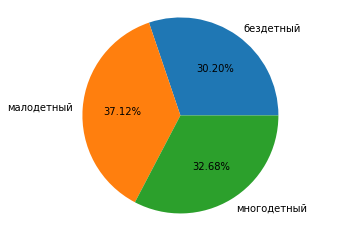

In [70]:
plt.pie(children_corr['%'].values, labels = children_corr.index, autopct='%0.2f%%')
plt.axis('equal')
plt.show()

### Вывод

**1. Есть зависимость между наличием детей и возвратом кредита в срок: малодетные заемщики относительно чаще допускат просрочку в возврате кредита, следом за ними идут многодетные, а лучше всех справляются бездетные заемщики.**

**2. В полученной выборке:**
- 9.27 % от малодетных заемщиков просрочили возврат кредита,
- 8.16 % от многодетных заемщиков просрочили возврат кредита,
- 7.54 % от бездетных заемщиков просрочили возврат кредита.

### - Есть ли зависимость между семейным положением и возвратом кредита в срок?

Сведем данные в сводную таблицу, дополним таблицу процентом невозвратов кредита по каждому из статусов

In [71]:
family_corr = pd.pivot_table(categorized_df, 'debt', index = 'family_status_flexed', columns=['debt_double'], aggfunc='count')
family_corr['%'] = round((family_corr['есть долг'] / (family_corr['нет долга'] + family_corr['есть долг']))*100, 2)
family_corr.sort_values('%')

debt_double,есть долг,нет долга,%
family_status_flexed,,,
женат,1319,15171,8.0
одинокий,422,4542,8.5


Визуализируем соотношение между категориями заемщиков, просрочивших долг

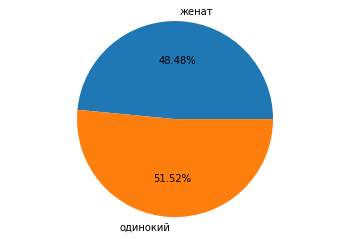

In [72]:
plt.pie(family_corr['%'].values, labels = family_corr.index, autopct='%0.2f%%')
plt.axis('equal')
plt.show()

### Вывод

**1. Существенной корреляции между семейным положением и возвратом кредитов не наблюдается: и одинокие и женатые примерно одинаково допускают просочки в платежах.**

**2. В полученной выборке:**
- 8.0 % женатых заемщиков просрочили возврат кредита
- 8.5 % одиноких заемщиков просрочили возврат кредита

### - Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Сведем данные в сводную таблицу, дополним таблицу процентом невозвратов кредита по каждому из статусов

In [73]:
income_corr = pd.pivot_table(categorized_df, 'debt', index = 'total_income_category', columns=['debt_double'], aggfunc='count')
income_corr['%'] = round((income_corr['есть долг'] / (income_corr['нет долга'] + income_corr['есть долг']))*100, 2)
income_corr.sort_values('%')

debt_double,есть долг,нет долга,%
total_income_category,,,
низкий,13,189,6.44
высокий,216,2889,6.96
средний,1512,16635,8.33


Визуализируем соотношение между категориями заемщиков, просрочивших долг

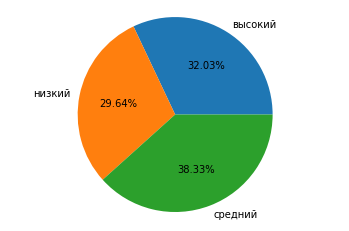

In [74]:
plt.pie(income_corr['%'].values, labels = income_corr.index, autopct='%0.2f%%')
plt.axis('equal')
plt.show()

### Вывод

**1. Уровень дохода влияет на вероятность просрочки: заемщики со средним доходом чаще нарушают сроки возврата кредита, чем заемщики с низким и высоким доходом, которые справляются примерно одинаково.**

**2. В полученной выборке:**
- 8.33 % от заемщиков со средним доходом просрочили возврат кредита,
- 6.96 % от заемщиков с высоким доходом  просрочили возврат кредита,
- 6.44 % от заемщиков с низким доходом просрочили возврат кредита.

### - Как разные цели кредита влияют на его возврат в срок?

Сведем данные в сводную таблицу, дополним таблицу процентом невозвратов кредита по каждому из статусов

In [75]:
purpose_corr = pd.pivot_table(categorized_df, 'debt', index = 'purpose_categorized', columns=['debt_double'], aggfunc = 'count')
purpose_corr['%'] = round((purpose_corr['есть долг'] / (purpose_corr['нет долга']+purpose_corr['есть долг']))*100, 2)
purpose_corr.sort_values('%')

debt_double,есть долг,нет долга,%
purpose_categorized,,,
ремонт,35,572,5.77
недвижимость,747,9457,7.32
свадьба,186,2138,8.00
образование,370,3643,9.22
автомобиль,403,3903,9.36


Визуализируем соотношение между категориями заемщиков, просрочивших долг

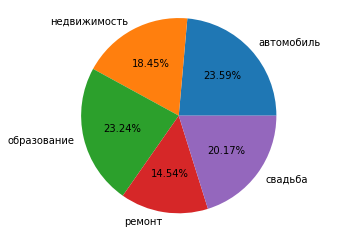

In [76]:
plt.pie(purpose_corr['%'].values, labels = purpose_corr.index, autopct='%0.2f%%')
plt.axis('equal')
plt.show()

### Вывод

**1. Цель кредита влияет на возврат в срок - в наблюдениях есть существенный разброс:** 
- чаще всего не отдают кредиты, полученные на покупку автомобиля и образование,
- следом идут кредиты на организацию свадьбы,
- затем кредиты на недвижимость - ипотечное кредитование,
- менее всего просрочек в кредитах на ремонт жилья.

**2. В полученной выборке:**
- 9.36 % от кредитов на покупку автомобиля не вернули в срок,
- 9.22 % от кредитов на образование не вернули в срок,
- 8.0 % от кредитов на организацию свадьбы не вернули в срок,
- 7.32 % от кредитов на покупку недвижимости не вернули в срок,
- 5.77 % от кредитов на ремонт жилья не вернули в срок,

# Общий вывод

### Общие выводы о полученных данных:
1. Данные со сведениями о возврате кредита в срок были загружены, очищены, категоризированы и проанализированы.
2. В полученных данных были выявлены 5 868‬ из 21 525 строк (27 %) с пропусками, бессмысленными данными и дубликатами.
3. Ниболее существенной проблемой оказались не пропущенные значения и дубликаты, а бессмысленные данные. В первую очередь данные в столбце с непрерывным стажем работы в днях - потребовалась грубая замена в 3445 строках на предельно возможный стаж. Возможно ошибка носит системный характер и требуется выяснить причину появления бессмысленных значений в таком количестве.
4. Также в данных более 15 000 наблюдений с отрицательными значениями. В данном случае, наболее вероятная причина в появлении ошибок - способ получения данных, что возможно исправить.


### Ответы на поставленные вопросы:
1. Семейное положение не влияет на факт погашения кредита в срок.
2. Количество детей клиента влияет на факт погашения кредита в срок - малодетные заемщики относительно чаще допускат просрочку в возврате кредита, следом за ними идут многодетные, а лучше всех справляются бездетные заемщики.
3. Уровень дохода заемщика влияет на факт погашения кредита в срок: заемщики со средним доходом чаще нарушают сроки возврата кредита, чем заемщики с низким и высоким доходом, которые справляются примерно одинаково.
4. Цель кредита влияет на возврат в срок - в наблюдениях есть существенный разброс в зависимости от цели кредита: чаще всего не отдают кредиты, полученные на покупку автомобиля и образование, следом идут кредиты на организацию свадьбы, затем кредиты на недвижимость - ипотечное кредитование, менее всего просрочек в кредитах на ремонт жилья. 
    
    
### Вместе с тем, необходимо озвучить ограничения исследования:
1. В целом анализ направлен на исследование социального положения заемщика, которое позволяет полезно исследовать для получения психологического портрета заемщика, предугадать шаблоны поведения. Для кредитного скоринга скорее необходима информация о количестве ранее полученных кредитов, сумме кредитов, количество отказов в выдаче кредитов, способ оплаты кредита и сам факт допущения просрочки, срок просрочки и количество невозвращенных кредитов. То есть, требуются те данные, которые не представлены в таблице. 
2. Таким образом, исследование полезно разве что для предварительной поверхностной оценки заемщика при получении завки на выдачу кредита.
3. Неясно, что именно подразумеватеся под debt в таблице: невозврат или просрочку? Это существенно, потому что ипотечные кредиты обеспечены залогом, а просрочка может быть кратковременной.
4. Сама по себе информация о ежемесячном доходе малоинформативна и представляется малополезной сама по себе (если отбросить вопросы правового характера и здравый смысл - доход должен быть). Гораздо больше ежемесячного доход скажет в связке с общим доходом семьи и количеством детей.
5. Представляется, что информация о сумме кредита могла бы сказать гораздо больше о потенциальных причинах нарушения срока возврата кредита.